# Telecom churn case study...

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn.

In [1]:
#Importing Basic Libraries...

import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew
from scipy.stats import uniform

from scipy import stats
from scipy.stats import norm, skew #for some statistics


In [2]:
# This script is to ignore warnings in our python code file.
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Reading Train and Test data.
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

In [4]:
print(train.shape)
print(test.shape)

(69999, 172)
(30000, 171)


In [5]:
train.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


# Step1: Data understanding, preparation & pre-processing

After data has been imported let us review it based on dictionary we have and perform data cleaning and basic pre-processing steps which needs to be done to run all basic algorithms.

In [6]:
#Print null counts by column
train.isnull().sum()

id                     0
circle_id              0
loc_og_t2o_mou       702
std_og_t2o_mou       702
loc_ic_t2o_mou       702
                    ... 
aon                    0
aug_vbc_3g             0
jul_vbc_3g             0
jun_vbc_3g             0
churn_probability      0
Length: 172, dtype: int64

Let us check how many missing values we have in our dataframe.

In [7]:
# Creating function definitions to check and visualize % of missing columns.
def missing_data(df, graph):
    df_na = (df.isnull().sum() / len(df)) * 100
    df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :df_na})
    if graph:
        df_na = df_na[:30]
        f, ax = plt.subplots(figsize=(10, 8))
        plt.xticks(rotation='90')
        sns.barplot(x=df_na.index, y=df_na)
        plt.xlabel('Features', fontsize=15)
        plt.ylabel('Percent of missing values', fontsize=15)
        plt.title('Percent missing data by feature', fontsize=15)
        plt.show()
    return missing_data

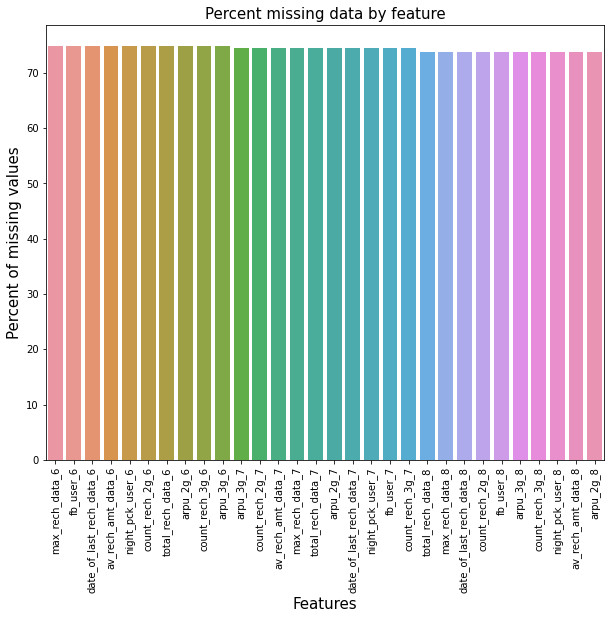

In [8]:
cols = missing_data(train, True)
cols = cols.reset_index()

In [9]:
cols

,index,Missing Ratio
0,max_rech_data_6,74.902499
1,fb_user_6,74.902499
2,date_of_last_rech_data_6,74.902499
3,av_rech_amt_data_6,74.902499
4,night_pck_user_6,74.902499
...,...,...
120,last_date_of_month_8,1.047158
121,std_og_t2o_mou,1.002871
122,loc_ic_t2o_mou,1.002871
123,loc_og_t2o_mou,1.002871


#### Let us see columns with more than 30% rows missing. We will drop these columns as they will not be much of use in our study.

In [10]:
cols_with_high_missing_values = (cols[cols["Missing Ratio"] > 30]).iloc[:, 0]
cols_with_high_missing_values.to_list()

['max_rech_data_6',
 'fb_user_6',
 'date_of_last_rech_data_6',
 'av_rech_amt_data_6',
 'night_pck_user_6',
 'count_rech_2g_6',
 'total_rech_data_6',
 'arpu_2g_6',
 'count_rech_3g_6',
 'arpu_3g_6',
 'arpu_3g_7',
 'count_rech_2g_7',
 'av_rech_amt_data_7',
 'max_rech_data_7',
 'total_rech_data_7',
 'arpu_2g_7',
 'date_of_last_rech_data_7',
 'night_pck_user_7',
 'fb_user_7',
 'count_rech_3g_7',
 'total_rech_data_8',
 'max_rech_data_8',
 'date_of_last_rech_data_8',
 'count_rech_2g_8',
 'fb_user_8',
 'arpu_3g_8',
 'count_rech_3g_8',
 'night_pck_user_8',
 'av_rech_amt_data_8',
 'arpu_2g_8']

In [11]:
def remove_missing_column(df):
    df = df.drop(cols_with_high_missing_values,axis=1, errors='ignore')
    print(df.shape)
    return df

In [12]:
train = remove_missing_column(train)

(69999, 142)


In [13]:
train.shape

(69999, 142)

In [14]:
missing_data(train, False)

,Missing Ratio
std_og_t2c_mou_8,5.290076
loc_og_mou_8,5.290076
loc_og_t2m_mou_8,5.290076
loc_ic_t2f_mou_8,5.290076
loc_og_t2f_mou_8,5.290076
...,...
last_date_of_month_8,1.047158
std_og_t2o_mou,1.002871
loc_ic_t2o_mou,1.002871
loc_og_t2o_mou,1.002871


#### We see there are still rows with missing values, let us handle them as well.

In [15]:
id_cols = ["id", "circle_id"]
date_cols = ["last_date_of_month_6", "last_date_of_month_7", "last_date_of_month_8", "date_of_last_rech_6", "date_of_last_rech_data_7", "date_of_last_rech_8", "date_of_last_rech_data_6", "date_of_last_rech_7", "date_of_last_rech_data_8"]

# divide the data into numerical ("quan") and categorical ("qual") features, to make processing steps much easier.
numeric_cols = list(set( train.loc[:,train.dtypes != 'object'].columns.values ) - set(id_cols + date_cols))
categorial_cols = list(set( train.loc[:,train.dtypes == 'object'].columns.values )- set(id_cols + date_cols))

print("id_cols", id_cols)
print("date_cols", date_cols)
print("numeric_cols", numeric_cols)
print("categorial_cols", categorial_cols)

id_cols ['id', 'circle_id']
date_cols ['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'date_of_last_rech_6', 'date_of_last_rech_data_7', 'date_of_last_rech_8', 'date_of_last_rech_data_6', 'date_of_last_rech_7', 'date_of_last_rech_data_8']
numeric_cols ['loc_og_t2m_mou_6', 'std_ic_t2f_mou_6', 'std_og_t2f_mou_7', 'sachet_2g_8', 'vol_3g_mb_8', 'loc_og_t2t_mou_8', 'monthly_2g_7', 'roam_og_mou_8', 'sachet_3g_8', 'offnet_mou_7', 'roam_ic_mou_8', 'spl_og_mou_8', 'std_ic_t2f_mou_8', 'loc_ic_t2m_mou_7', 'max_rech_amt_6', 'roam_ic_mou_6', 'sachet_2g_7', 'offnet_mou_8', 'sachet_3g_6', 'std_og_t2m_mou_7', 'loc_og_t2t_mou_6', 'loc_ic_t2f_mou_6', 'total_og_mou_6', 'std_ic_t2m_mou_6', 'sachet_2g_6', 'last_day_rch_amt_7', 'total_rech_amt_6', 'vol_3g_mb_7', 'std_ic_t2t_mou_7', 'std_ic_t2f_mou_7', 'onnet_mou_8', 'std_ic_mou_6', 'max_rech_amt_7', 'std_og_t2o_mou', 'monthly_3g_8', 'onnet_mou_7', 'loc_og_t2f_mou_6', 'std_og_t2t_mou_6', 'std_og_t2f_mou_6', 'std_og_mou_7', 'og_others

# Step2: EDA and Feature Engineering
Feature Engineering i.e. one or more methods on attributes that lead to the creation of a new potentially useful variable.

### Understanding/Assumption...
Based on the data dictionary any column with combination of Mou i.e. **Minutes of usage** and **Outgoing/Incoming calls** has value based on time spend or money spent. Here we assume value as 0 wherever we have Null values.

In [16]:
## any mou missing, lets consider them didnt happen, i.e. 0
## any og missing, lets consider them didnt happen, i.e. 0
## any ic missing, lets consider them didnt happen, i.e. 0
# Function for imputing data.
def data_imputation(df):
    for col in df.columns:
        if "mou" in col:
            df[col] = df[col].fillna(0)
        if "og" in col:
            df[col] = df[col].fillna(0)
        if "ic" in col:
            df[col] = df[col].fillna(0)
            
    return df



In [17]:
train = data_imputation(train)

In [18]:
missing_data(train, False)

,Missing Ratio
date_of_last_rech_8,3.515765
date_of_last_rech_7,1.762882
date_of_last_rech_6,1.572880
last_date_of_month_8,1.047158
last_date_of_month_7,0.570008


Successful data imputation is done for Categorical and Numerical columns. Now we see only date columns have missing values, let us process them as well.

In [19]:
train["date_of_last_rech_8"].value_counts()

8/31/2014    10324
8/30/2014     8187
8/29/2014     6995
8/28/2014     6843
8/26/2014     6525
8/25/2014     5469
8/24/2014     5375
8/27/2014     4012
8/22/2014     1421
8/20/2014     1361
8/23/2014     1262
8/19/2014     1114
8/21/2014      936
8/18/2014      727
8/9/2014       703
8/5/2014       669
8/14/2014      601
8/15/2014      574
8/16/2014      544
8/13/2014      512
8/17/2014      501
8/12/2014      499
8/8/2014       483
8/6/2014       430
8/11/2014      388
8/7/2014       294
8/10/2014      248
8/1/2014       171
8/2/2014       147
8/4/2014       128
8/3/2014        95
Name: date_of_last_rech_8, dtype: int64

In [20]:
train["last_date_of_month_8"].value_counts()

8/31/2014    69266
Name: last_date_of_month_8, dtype: int64

#### For "last_date_of_month" columns we have all values same for all rows. 
These columns will not hold any significance toward our target variable. There is no variance to be explained with these 3 columns, let us remove them.

In [21]:
### last_date_of_month-* delete
def unnecessary_columns_drop(df):
    for col in df.columns:
        if "last_date_of_month" in col:
            df = df.drop([col],axis=1, errors='ignore')
    print(df.shape)
    return df
    

In [22]:
train = unnecessary_columns_drop(train)

(69999, 139)


## Derive metrics
### We cannot use date column in our algorithm to make any predictions, lets convert them into quantifiable metrics.
We will make columns based on whether recharge was done in that particular month or not.

In [23]:
date_cols

['last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'date_of_last_rech_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_7',
 'date_of_last_rech_data_8']

In [24]:
train[train["date_of_last_rech_6"].isnull() == True]["date_of_last_rech_6"]

28       NaN
95       NaN
293      NaN
351      NaN
498      NaN
        ... 
69841    NaN
69863    NaN
69868    NaN
69931    NaN
69978    NaN
Name: date_of_last_rech_6, Length: 1101, dtype: object

In [25]:
# Function to convert date columns into categorical and drop them simultaneously.
def convert_recharge_date_yes_no(df):
    for col in df.columns:
        if "date_of_last_rech" in col:
            df["rech" + col.replace("date_of_last_rech", "")] =  [1 if x != None else 0 for x in df[col]]
            df = df.drop([col],axis=1, errors='ignore')
    print(df.shape)
    return df

In [26]:
train = convert_recharge_date_yes_no(train)

(69999, 139)


In [27]:
missing_data(train, False)

,Missing Ratio


#### Finally, there are no missing variables in our dataset. Let's do some visual analysis and finally run our models when we are done.

In [28]:
# check circle_id
train["circle_id"].value_counts()

109    69999
Name: circle_id, dtype: int64

#### Mobile number is unique and all circle id is same for all rows, hence we can drop as there will be no significance of this variable toward predicting target variable.

In [29]:
def drop_ids(df):
    df = df.drop(id_cols,axis=1, errors='ignore')
    print(df.shape)
    return df

In [30]:
train = drop_ids(train)

(69999, 137)


## Univariate and Bivariate Analysis
### Heatmaps

#### Lets validate different columns and distributions

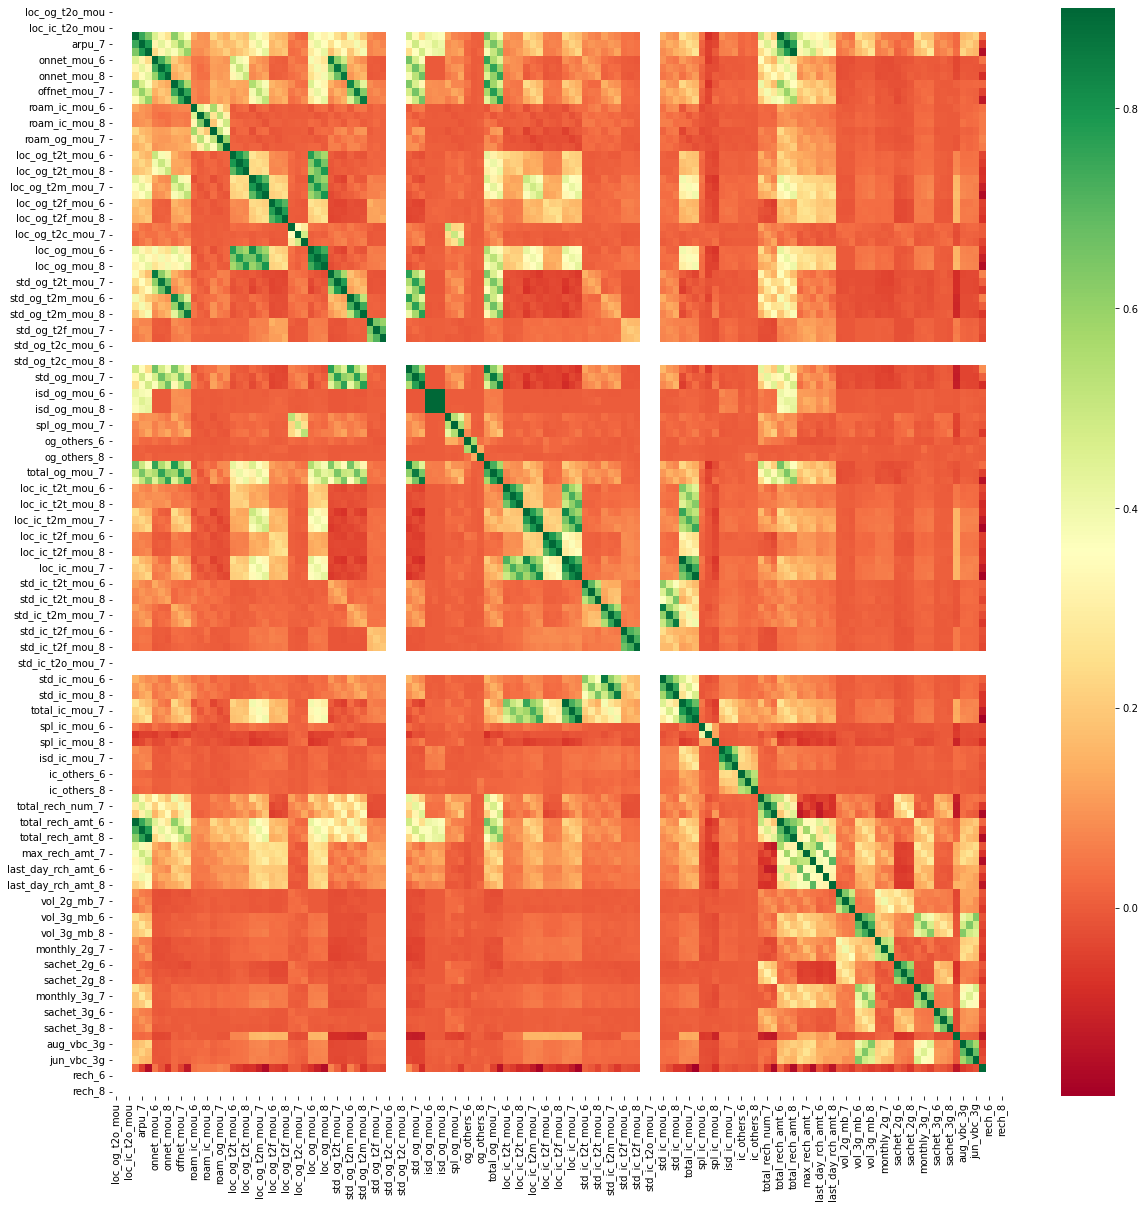

In [31]:
#Correlation map to see how features are correlated
corrmat = train.corr()
plt.subplots(figsize=(20,20))
sns.heatmap(corrmat, vmax=0.9, annot=False,cmap="RdYlGn")
plt.show()

#### Let us drop the columns that are not strongly correlated.

In [32]:
train_corr_data = train.corr()
# top_corr_num_col = train_corr_data.index[abs(train_corr_data['churn_probability'])>0.3]
# top_corr_num_col

In [33]:
train_corr_data[train_corr_data['churn_probability'].isna()]['churn_probability']

loc_og_t2o_mou     NaN
std_og_t2o_mou     NaN
loc_ic_t2o_mou     NaN
std_og_t2c_mou_6   NaN
std_og_t2c_mou_7   NaN
std_og_t2c_mou_8   NaN
std_ic_t2o_mou_6   NaN
std_ic_t2o_mou_7   NaN
std_ic_t2o_mou_8   NaN
rech_6             NaN
rech_7             NaN
rech_8             NaN
Name: churn_probability, dtype: float64

#### The above columns are not corelated, hence can be deleted.

In [34]:
tmp_data = (train_corr_data[train_corr_data['churn_probability'].isna()]['churn_probability'])

In [35]:
non_corelated_cols = tmp_data.index.values.tolist() 

In [36]:
def drop_unrelated_cols(df):
    df = df.drop(non_corelated_cols,axis=1, errors='ignore')
    print(df.shape)
    return df

In [37]:
train = drop_unrelated_cols(train)

(69999, 125)


In [38]:
## recalculating numeric_cols
numeric_cols = list(set( train.loc[:,train.dtypes != 'object'].columns.values ) - set(id_cols + date_cols))

## Plots graphs

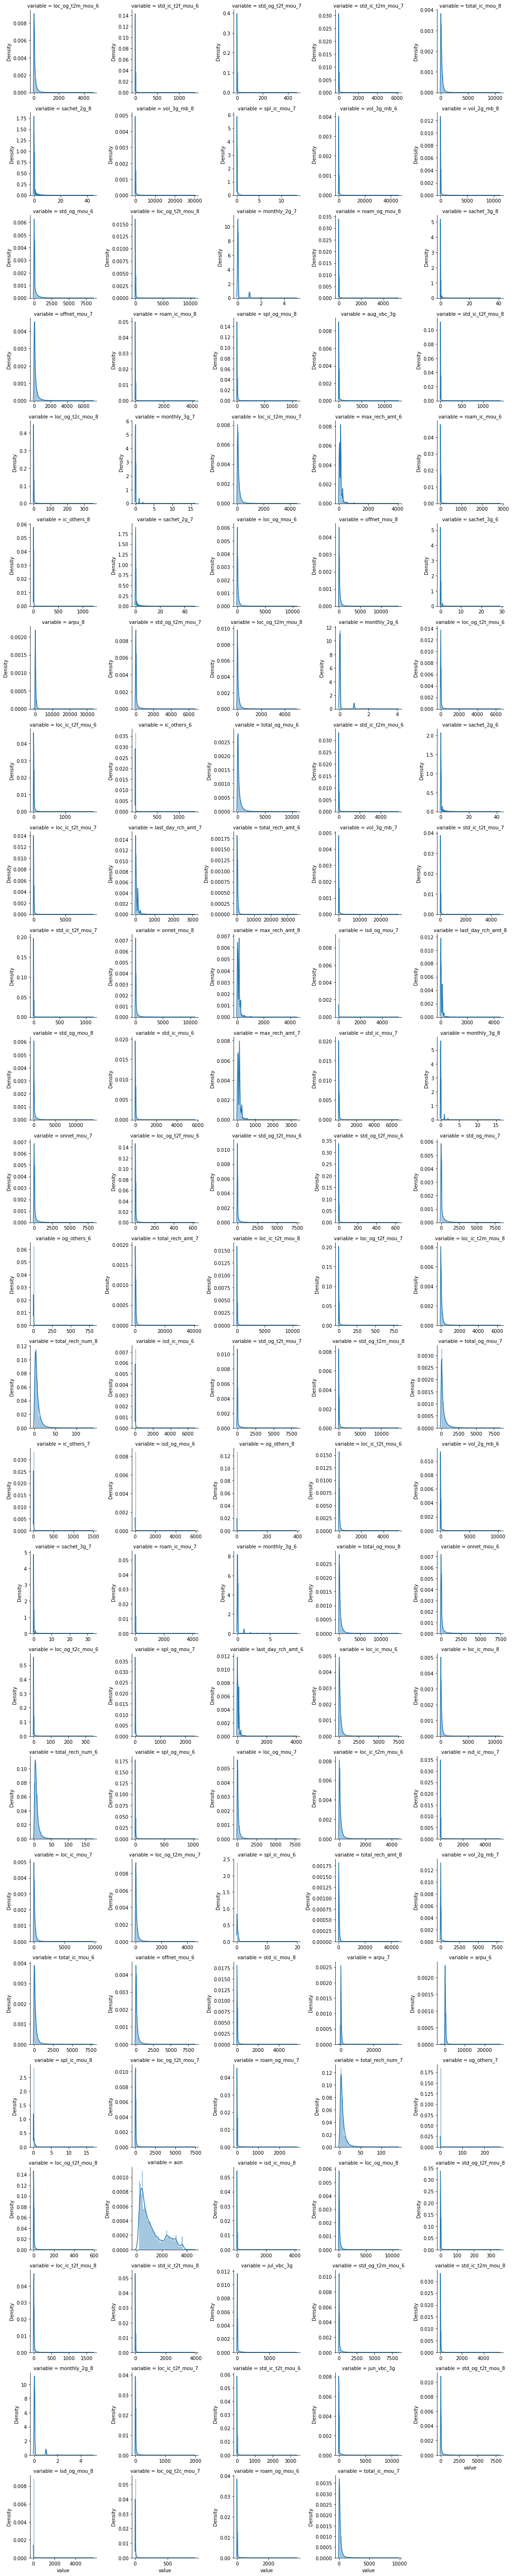

In [39]:
# visualize the distribution of each numerical feature
temp = train.melt(id_vars=['churn_probability'], value_vars= numeric_cols )
grid = sns.FacetGrid(temp, col="variable",  col_wrap=5 , size=3.0, 
                     aspect=1.0,sharex=False, sharey=False)
grid.map(sns.distplot, "value")
plt.show()

In [40]:
def data_type(variable):
    if variable.dtype == np.int64 or variable.dtype == np.float64:
        return 'numerical'
    elif variable.dtype == 'category':
        return 'categorical'
    
def bivariate(var1, var2):
    if data_type(var1) == 'numerical' and data_type(var2) == 'numerical':
        sns.regplot(var1, var2)
    elif (data_type(var1) == 'categorical' and data_type(var2) == 'numerical') or (data_type(var1) == 'numerical' and data_type(var2) == 'categorical'):        
        sns.boxplot(var1, var2)
    plt.show()


In [41]:
#for col in train.columns:
    #if (col != "churn_probability"):
        #bivariate(train[col], train["churn_probability"])

In [42]:
## eda apply on test data

def eda(df):
    df = remove_missing_column(df)
    df = data_imputation(df)
    df = unnecessary_columns_drop(df)
    df = convert_recharge_date_yes_no(df)
    df = drop_ids(df)
    df = drop_unrelated_cols(df)
    return df
    


# Model selection, model building, evaluation & prediction

#### Let us split our training data into train and test models...

In [43]:
# x and y split
#y to contain only target variable
y=train.pop('churn_probability')

#X is all remainign variable also our independent variables
X=train

#Train Test split with 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [44]:
# Checking shape and size for train and test
print(X_train.shape)
print(X_test.shape)

(48999, 124)
(21000, 124)


In [45]:
# Importing required library
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

## Build a Model using RFE and Automated approach

As our overall dataframe has more than 150 features, manual approach will not work. We are going to do automated approach to find and use features with highest relevance

In [46]:
# Build a Lienar Regression model using SKLearn for RFE
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [47]:
#Cut down number of features to 15 using automated approach
rfe = RFE(lr,15)
rfe.fit(X_train,y_train)

RFE(estimator=LinearRegression(), n_features_to_select=15)

In [48]:
#Columns selected by RFE and their weights
list(zip(X_train.columns,rfe.support_,rfe.ranking_))


[('arpu_6', False, 85),
 ('arpu_7', False, 90),
 ('arpu_8', False, 96),
 ('onnet_mou_6', False, 95),
 ('onnet_mou_7', False, 75),
 ('onnet_mou_8', False, 89),
 ('offnet_mou_6', False, 93),
 ('offnet_mou_7', False, 74),
 ('offnet_mou_8', False, 82),
 ('roam_ic_mou_6', False, 80),
 ('roam_ic_mou_7', False, 92),
 ('roam_ic_mou_8', False, 98),
 ('roam_og_mou_6', False, 94),
 ('roam_og_mou_7', False, 73),
 ('roam_og_mou_8', False, 83),
 ('loc_og_t2t_mou_6', False, 54),
 ('loc_og_t2t_mou_7', False, 36),
 ('loc_og_t2t_mou_8', True, 1),
 ('loc_og_t2m_mou_6', False, 53),
 ('loc_og_t2m_mou_7', False, 35),
 ('loc_og_t2m_mou_8', True, 1),
 ('loc_og_t2f_mou_6', False, 52),
 ('loc_og_t2f_mou_7', False, 34),
 ('loc_og_t2f_mou_8', True, 1),
 ('loc_og_t2c_mou_6', False, 76),
 ('loc_og_t2c_mou_7', False, 77),
 ('loc_og_t2c_mou_8', False, 78),
 ('loc_og_mou_6', False, 17),
 ('loc_og_mou_7', False, 37),
 ('loc_og_mou_8', False, 50),
 ('std_og_t2t_mou_6', False, 18),
 ('std_og_t2t_mou_7', False, 39),
 ('st

### Ridge Regression

Let us try model using Ridge Regression.

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso

In [50]:
lm_ridge = Ridge()

parameters= {'alpha':[x for x in [0.0005,0.001,0.01,0.1,0.2,0.4,0.5,0.7,0.8,1]]}
lm_ridge_grd = GridSearchCV(estimator = lm_ridge, param_grid=parameters)

lm_ridge_grd.fit(X_train,y_train)

print("The best value of Alpha is: ",lm_ridge_grd.best_params_,lm_ridge_grd.best_score_)

The best value of Alpha is:  {'alpha': 0.0005} 0.2228723326749315


In [51]:
lm_ridge_best_gcv = lm_ridge_grd.best_estimator_
lm_ridge_best_gcv

Ridge(alpha=0.0005)

In [52]:
lm_ridge_best_gcv.fit(X_train,y_train)


Ridge(alpha=0.0005)

In [53]:
# Prediction
y_pred_train_ridge_gcv = lm_ridge_best_gcv.predict(X_train)
y_pred_test_ridge_gcv =  lm_ridge_best_gcv.predict(X_test)

In [54]:
print('Root Mean Square Error train = ' + str(np.sqrt(mean_squared_error(y_train, y_pred_train_ridge_gcv))))
print('Root Mean Square Error test = ' + str(np.sqrt(mean_squared_error(y_test, y_pred_test_ridge_gcv)))) 

Root Mean Square Error train = 0.2662391195951889
Root Mean Square Error test = 0.2640328347575141


In [55]:
# ridge model parameters
model_parameters = list(lm_ridge_best_gcv.coef_)
model_parameters.insert(0, lm_ridge_best_gcv.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
list(zip(cols, model_parameters))

[('constant', 0.343),
 ('arpu_6', 0.0),
 ('arpu_7', 0.0),
 ('arpu_8', -0.0),
 ('onnet_mou_6', 0.0),
 ('onnet_mou_7', -0.001),
 ('onnet_mou_8', 0.0),
 ('offnet_mou_6', 0.0),
 ('offnet_mou_7', -0.001),
 ('offnet_mou_8', -0.0),
 ('roam_ic_mou_6', 0.0),
 ('roam_ic_mou_7', 0.0),
 ('roam_ic_mou_8', -0.0),
 ('roam_og_mou_6', -0.0),
 ('roam_og_mou_7', 0.001),
 ('roam_og_mou_8', 0.0),
 ('loc_og_t2t_mou_6', 0.702),
 ('loc_og_t2t_mou_7', 1.485),
 ('loc_og_t2t_mou_8', 4.871),
 ('loc_og_t2m_mou_6', 0.702),
 ('loc_og_t2m_mou_7', 1.486),
 ('loc_og_t2m_mou_8', 4.871),
 ('loc_og_t2f_mou_6', 0.702),
 ('loc_og_t2f_mou_7', 1.486),
 ('loc_og_t2f_mou_8', 4.871),
 ('loc_og_t2c_mou_6', -0.001),
 ('loc_og_t2c_mou_7', 0.0),
 ('loc_og_t2c_mou_8', 0.0),
 ('loc_og_mou_6', -1.8),
 ('loc_og_mou_7', -1.327),
 ('loc_og_mou_8', -0.534),
 ('std_og_t2t_mou_6', -1.685),
 ('std_og_t2t_mou_7', -1.033),
 ('std_og_t2t_mou_8', 2.338),
 ('std_og_t2m_mou_6', -1.685),
 ('std_og_t2m_mou_7', -1.032),
 ('std_og_t2m_mou_8', 2.338),
 

In [56]:
# Create a dataframe for Ridge Coefficients
mod_ridge = list(zip(cols, model_parameters))
paraRFE = pd.DataFrame(mod_ridge)
paraRFE.columns = ['Variable', 'Coeff']
res=paraRFE.sort_values(by=['Coeff'], axis = 0, ascending = False)
res.head(20)

,Variable,Coeff
60,loc_ic_t2m_mou_8,7.148
63,loc_ic_t2f_mou_8,7.148
57,loc_ic_t2t_mou_8,7.148
90,ic_others_8,5.396
87,isd_ic_mou_8,5.396
84,spl_ic_mou_8,5.314
21,loc_og_t2m_mou_8,4.871
24,loc_og_t2f_mou_8,4.871
18,loc_og_t2t_mou_8,4.871
45,isd_og_mou_8,4.337


In [57]:
# Sorting the coefficients in ascending order
paraRFE = paraRFE.sort_values((['Coeff']), axis = 0, ascending = False)
paraRFE

,Variable,Coeff
60,loc_ic_t2m_mou_8,7.148
63,loc_ic_t2f_mou_8,7.148
57,loc_ic_t2t_mou_8,7.148
90,ic_others_8,5.396
87,isd_ic_mou_8,5.396
...,...,...
73,std_ic_t2f_mou_6,-2.026
64,loc_ic_mou_6,-2.034
65,loc_ic_mou_7,-2.360
54,total_og_mou_8,-4.337


In [58]:
## since there were few coefficients at 0, we removed them from features
predRFE = pd.DataFrame(paraRFE[(paraRFE['Coeff'] != 0)])
predRFE

,Variable,Coeff
60,loc_ic_t2m_mou_8,7.148
63,loc_ic_t2f_mou_8,7.148
57,loc_ic_t2t_mou_8,7.148
90,ic_others_8,5.396
87,isd_ic_mou_8,5.396
...,...,...
73,std_ic_t2f_mou_6,-2.026
64,loc_ic_mou_6,-2.034
65,loc_ic_mou_7,-2.360
54,total_og_mou_8,-4.337


In [59]:
Ridge_var = list(predRFE['Variable'])
print(Ridge_var)

['loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'loc_ic_t2t_mou_8', 'ic_others_8', 'isd_ic_mou_8', 'spl_ic_mou_8', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_8', 'loc_og_t2t_mou_8', 'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'std_ic_mou_8', 'loc_ic_t2m_mou_7', 'loc_ic_t2t_mou_7', 'loc_ic_t2f_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'std_og_mou_8', 'std_ic_mou_7', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_7', 'loc_og_t2t_mou_7', 'loc_ic_t2f_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_t2t_mou_6', 'std_ic_mou_6', 'std_og_mou_7', 'total_og_mou_6', 'loc_og_t2f_mou_6', 'loc_og_t2m_mou_6', 'loc_og_t2t_mou_6', 'total_ic_mou_6', 'std_og_mou_6', 'isd_ic_mou_7', 'ic_others_7', 'spl_ic_mou_7', 'constant', 'isd_og_mou_7', 'spl_og_mou_7', 'og_others_7', 'sachet_3g_7', 'sachet_3g_6', 'total_rech_num_6', 'sachet_2g_6', 'roam_og_mou_7', 'total_rech_num_7', 'monthly_3g_6', 'onnet_mou_7', 'offnet_mou_7', 'loc_og_t2c_mou_6', 'sachet_2g_7', 'sa

### LASSO

Let us try model using Lasso Regression.

In [60]:
lm_lasso =Lasso()
parameters= {'alpha':[x for x in [0.0005,0.001,0.01,0.1,0.2,0.4,0.5,0.7,0.8,1]]}

In [61]:
lm_lasso_grd = GridSearchCV(estimator=lm_lasso, 
                            param_grid=parameters)

In [62]:
lm_lasso_grd.fit(X_train,y_train)

print("The best value of Alpha is: ",lm_lasso_grd.best_params_,lm_lasso_grd.best_score_)

The best value of Alpha is:  {'alpha': 0.0005} 0.13416694841510257


In [63]:
lm_lasso_best_gcv = lm_lasso_grd.best_estimator_
lm_lasso_best_gcv

Lasso(alpha=0.0005)

In [64]:
lm_lasso_best_gcv.fit(X_train,y_train)

Lasso(alpha=0.0005)

In [65]:
# Prediction
y_pred_train_lasso_gcv = lm_lasso_best_gcv.predict(X_train)
y_pred_test_lasso_gcv =  lm_lasso_best_gcv.predict(X_test)

In [66]:
print('Root Mean Square Error train = ' + str(np.sqrt(mean_squared_error(y_train, y_pred_train_lasso_gcv))))
print('Root Mean Square Error test = ' + str(np.sqrt(mean_squared_error(y_test, y_pred_test_lasso_gcv))))

Root Mean Square Error train = 0.2808390366579877
Root Mean Square Error test = 0.2786229632977172


In [67]:
print("R-Square for training data",lm_lasso_best_gcv.score(X_train,y_train)) 
print("R-Square for test data",lm_lasso_best_gcv.score(X_test,y_test))

R-Square for training data 0.14425278015017995
R-Square for test data 0.13707076524206485


In [68]:
# lasso model parameters
model_parameters = list(lm_lasso_best_gcv.coef_ )
model_parameters.insert(0, lm_lasso_best_gcv.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
list(zip(cols, model_parameters))


[('constant', 0.232),
 ('arpu_6', 0.0),
 ('arpu_7', 0.0),
 ('arpu_8', -0.0),
 ('onnet_mou_6', -0.0),
 ('onnet_mou_7', 0.0),
 ('onnet_mou_8', 0.0),
 ('offnet_mou_6', -0.0),
 ('offnet_mou_7', -0.0),
 ('offnet_mou_8', -0.0),
 ('roam_ic_mou_6', 0.0),
 ('roam_ic_mou_7', 0.0),
 ('roam_ic_mou_8', 0.0),
 ('roam_og_mou_6', 0.0),
 ('roam_og_mou_7', 0.0),
 ('roam_og_mou_8', 0.0),
 ('loc_og_t2t_mou_6', 0.0),
 ('loc_og_t2t_mou_7', -0.0),
 ('loc_og_t2t_mou_8', -0.0),
 ('loc_og_t2m_mou_6', 0.0),
 ('loc_og_t2m_mou_7', 0.0),
 ('loc_og_t2m_mou_8', 0.0),
 ('loc_og_t2f_mou_6', 0.0),
 ('loc_og_t2f_mou_7', 0.0),
 ('loc_og_t2f_mou_8', 0.0),
 ('loc_og_t2c_mou_6', -0.001),
 ('loc_og_t2c_mou_7', 0.0),
 ('loc_og_t2c_mou_8', 0.0),
 ('loc_og_mou_6', -0.0),
 ('loc_og_mou_7', 0.0),
 ('loc_og_mou_8', 0.0),
 ('std_og_t2t_mou_6', 0.0),
 ('std_og_t2t_mou_7', -0.0),
 ('std_og_t2t_mou_8', -0.0),
 ('std_og_t2m_mou_6', 0.0),
 ('std_og_t2m_mou_7', 0.0),
 ('std_og_t2m_mou_8', 0.0),
 ('std_og_t2f_mou_6', -0.0),
 ('std_og_t2f_m

In [69]:
# Creating a dataframe for the coefficients obtained from Lasso
mod = list(zip(cols, model_parameters))

para = pd.DataFrame(mod)
para.columns = ['Variable', 'Coeff']

para = para.sort_values((['Coeff']), axis = 0, ascending = False)
para.head(10)

,Variable,Coeff
0,constant,0.232
91,total_rech_num_6,0.002
112,sachet_2g_6,0.002
119,sachet_3g_7,0.001
118,sachet_3g_6,0.001
78,std_ic_mou_8,-0.000
74,std_ic_t2f_mou_7,-0.000
75,std_ic_t2f_mou_8,-0.000
76,std_ic_mou_6,0.000
77,std_ic_mou_7,-0.000


In [70]:
# Chose variables whose coefficients are non-zero
pred = pd.DataFrame(para[(para['Coeff'] != 0)])
pred

,Variable,Coeff
0,constant,0.232
91,total_rech_num_6,0.002
112,sachet_2g_6,0.002
119,sachet_3g_7,0.001
118,sachet_3g_6,0.001
117,monthly_3g_8,-0.001
25,loc_og_t2c_mou_6,-0.001
109,monthly_2g_6,-0.006
114,sachet_2g_8,-0.007
93,total_rech_num_8,-0.007


In [71]:
Lassso_var = list(pred['Variable'])
print(Lassso_var)

['constant', 'total_rech_num_6', 'sachet_2g_6', 'sachet_3g_7', 'sachet_3g_6', 'monthly_3g_8', 'loc_og_t2c_mou_6', 'monthly_2g_6', 'sachet_2g_8', 'total_rech_num_8', 'spl_ic_mou_7', 'monthly_2g_7', 'monthly_2g_8', 'spl_ic_mou_6', 'spl_ic_mou_8']


## We are done with logistic regression models, let us try other models and see which ones give better accuracy.

### RandomForest

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score

In [73]:
# random forest - the class weight is used to handle class imbalance - it adjusts the cost function
forest = RandomForestClassifier(class_weight={0:0.1, 1: 0.9}, n_jobs = -1)

# hyperparameter space
params = {"criterion": ['gini', 'entropy'], "max_features": ['auto', 0.4]}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=forest, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [74]:
# fit model
model.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=RandomForestClassifier(class_weight={0: 0.1, 1: 0.9},
                                              n_jobs=-1),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 0.4]},
             scoring='roc_auc', verbose=1)

In [75]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.9368580410377965
Best hyperparameters:  {'criterion': 'entropy', 'max_features': 0.4}


In [76]:
# predict churn on test data
y_pred = model.predict(X_test)

# create onfusion matrix
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

# check sensitivity and specificity
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

print("Sensitivity: \t", round(TP / float(TP+FN), 2), "\n", "Specificity: \t", round(TN / float(TN+FP), 2), sep='')

# check area under curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[18547   354]
 [  862  1237]]
Sensitivity: 	0.59
Specificity: 	0.98
AUC:    	 0.94


Let us check Precision and Recall from our analysis.

##### Precision
TP / TP + FP

##### Recall
TP / TP + FN

In [77]:
# positive predictive value 
print ("Precision")
print (TP / float(TP+FP))
# Negative predictive value
print ("Recall")
print(TN / float(TN+ FN))

Precision
0.7774984286612193
Recall
0.9555876139935081


### PCA

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [79]:
# apply pca to train data
pca = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])

In [80]:
pca.fit(X_train)
churn_pca = pca.fit_transform(X_train)

In [81]:
# extract pca model from pipeline
pca = pca.named_steps['pca']

# look at explainded variance of PCA components
print(pd.Series(np.round(pca.explained_variance_ratio_.cumsum(), 4)*100))

0       13.23
1       20.85
2       26.15
3       30.72
4       34.35
        ...  
119    100.00
120    100.00
121    100.00
122    100.00
123    100.00
Length: 124, dtype: float64


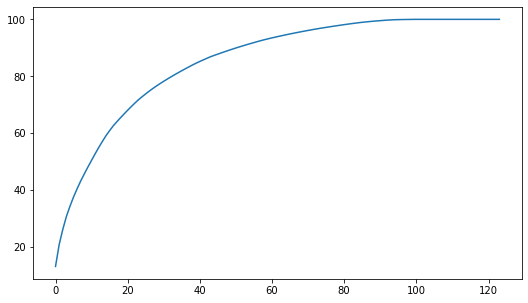

In [82]:
# plot feature variance
features = range(pca.n_components_)
cumulative_variance = np.round(np.cumsum(pca.explained_variance_ratio_)*100, decimals=4)
plt.figure(figsize=(175/20,100/20)) # 100 elements on y-axis; 175 elements on x-axis; 20 is normalising factor
plt.plot(cumulative_variance)
plt.show()

### PCA and Logistic Regression

In [83]:
# create pipeline
PCA_VARS = 60
steps = [('scaler', StandardScaler()),
         ("pca", PCA(n_components=PCA_VARS)),
         ("logistic", LogisticRegression(class_weight='balanced'))
        ]
pipeline = Pipeline(steps)

In [84]:
# fit model
#pipeline.fit(X_train, y_train)

# check score on train data
#pipeline.score(X_train, y_train)

In [85]:
# predict churn on test data
#y_pred = pipeline.predict(X_test)

# create onfusion matrix
#confusion = confusion_matrix(y_test, y_pred)
#print(confusion)

# check sensitivity and specificity
#TP = confusion[1,1] # true positive 
#TN = confusion[0,0] # true negatives
#FP = confusion[0,1] # false positives
#FN = confusion[1,0] # false negatives
#print("Sensitivity: \t", round(TP / float(TP+FN), 2), "\n", "Specificity: \t", round(TN / float(TN+FP), 2), sep='')

# check area under curve
#y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
#print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

Let us check Precision and Recall from our analysis.

##### Precision
TP / TP + FP

##### Recall
TP / TP + FN

In [86]:
# positive predictive value 
print ("Precision")
print (TP / float(TP+FP))
# Negative predictive value
print ("Recall")
print(TN / float(TN+ FN))

Precision
0.7774984286612193
Recall
0.9555876139935081


In [87]:
def evaluate_model(dt_classifier):
    print("Train Accuracy :", accuracy_score(y_train, dt_classifier.predict(X_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, dt_classifier.predict(X_train)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_test, dt_classifier.predict(X_test)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, dt_classifier.predict(X_test)))

In [88]:
#evaluate_model(pipeline)

### Hyperparameter tuning - PCA and Logistic Regression

In [115]:
# class imbalance
y_train.value_counts()/y_train.shape

0    0.897284
1    0.102716
Name: churn_probability, dtype: float64

In [116]:
# PCA
pca = PCA()

# logistic regression - the class weight is used to handle class imbalance - it adjusts the cost function
logistic = LogisticRegression(class_weight={0:0.1, 1: 0.9})

# create pipeline
steps = [("scaler", StandardScaler()), 
         ("pca", pca),
         ("logistic", logistic)
        ]

# compile pipeline
pca_logistic = Pipeline(steps)

# hyperparameter space
params = {'pca__n_components': [60, 80], 'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=pca_logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [121]:
# fit model
model.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('logistic',
                                        LogisticRegression(class_weight={0: 0.1,
                                                                         1: 0.9}))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
                         'logistic__penalty': ['l1', 'l2'],
                         'pca__n_components': [60, 80]},
             scoring='roc_auc', verbose=1)

In [122]:
# cross validation results
pd.DataFrame(model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,param_logistic__penalty,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.480342,0.081550,0.000000,0.000000,0.1,l1,60,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,32
1,6.711049,0.199278,0.000000,0.000000,0.1,l1,80,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,18
2,7.386245,0.304737,0.158973,0.043666,0.1,l2,60,"{'logistic__C': 0.1, 'logistic__penalty': 'l2'...",0.894402,0.885438,0.889715,0.891741,0.886634,0.889586,0.003279,15
3,9.073129,0.503266,0.141423,0.019842,0.1,l2,80,"{'logistic__C': 0.1, 'logistic__penalty': 'l2'...",0.899291,0.889526,0.891304,0.894280,0.886373,0.892155,0.004393,8
4,5.537589,0.512358,0.000000,0.000000,0.5,l1,60,"{'logistic__C': 0.5, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,22
5,7.110182,0.253884,0.000000,0.000000,0.5,l1,80,"{'logistic__C': 0.5, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,30
6,7.670285,0.243526,0.149001,0.015891,0.5,l2,60,"{'logistic__C': 0.5, 'logistic__penalty': 'l2'...",0.893764,0.886402,0.889557,0.891474,0.886869,0.889613,0.002776,14
7,9.460097,0.278374,0.136634,0.024035,0.5,l2,80,"{'logistic__C': 0.5, 'logistic__penalty': 'l2'...",0.898976,0.889823,0.891274,0.894321,0.886477,0.892174,0.004235,5
8,5.142646,0.301240,0.000000,0.000000,1,l1,60,"{'logistic__C': 1, 'logistic__penalty': 'l1', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,29
9,6.670158,0.190364,0.000000,0.000000,1,l1,80,"{'logistic__C': 1, 'logistic__penalty': 'l1', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,28


In [123]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.8922333908617468
Best hyperparameters:  {'logistic__C': 3, 'logistic__penalty': 'l2', 'pca__n_components': 80}


In [124]:
# predict churn on test data
y_pred = model.predict(X_test)

# create onfusion matrix
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

# check sensitivity and specificity
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
print("Sensitivity: \t", round(TP / float(TP+FN), 2), "\n", "Specificity: \t", round(TN / float(TN+FP), 2), sep='')

# check area under curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[14710  4191]
 [  289  1810]]
Sensitivity: 	0.86
Specificity: 	0.78
AUC:    	 0.89


In [125]:
# positive predictive value 
print ("Precision")
print (TP / float(TP+FP))
# Negative predictive value
print ("Recall")
print(TN / float(TN+ FN))

Precision
0.30161639726712214
Recall
0.9807320488032536


## PCA and Logistic Regression has best Sensitivity

### Choosing best features

In [126]:
# run a random forest model on train data
max_features = int(round(np.sqrt(X_train.shape[1])))    # number of variables to consider to split each node
print(max_features)

rf_model = RandomForestClassifier(n_estimators=100, max_features=max_features, class_weight={0:0.1, 1: 0.9}, oob_score=True, random_state=4, verbose=1)

11


In [98]:
# fit model
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   25.6s finished


RandomForestClassifier(class_weight={0: 0.1, 1: 0.9}, max_features=11,
                       oob_score=True, random_state=4, verbose=1)

In [99]:
# OOB score
rf_model.oob_score_

0.9394477438315068

In [100]:
len(X_train.columns)


124

In [101]:
# predict churn on test data
y_pred = rf_model.predict(X_test)

# create onfusion matrix
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

# check sensitivity and specificity
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
print("Sensitivity: \t", round(TP / float(TP+FN), 2), "\n", "Specificity: \t", round(TN / float(TN+FP), 2), sep='')

# check area under curve
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
print("ROC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[[18599   302]
 [  906  1193]]
Sensitivity: 	0.57
Specificity: 	0.98
ROC:    	 0.94


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


In [102]:
# positive predictive value 
print ("Precision")
print (TP / float(TP+FP))
# Negative predictive value
print ("Recall")
print(TN / float(TN+ FN))

Precision
0.7979933110367893
Recall
0.9535503716995642


### Feature Importance

In [103]:
# predictors
features = X_train.columns

# feature_importance
importance = rf_model.feature_importances_

# create dataframe
feature_importance = pd.DataFrame({'variables': features, 'importance_percentage': importance*100})
feature_importance = feature_importance[['variables', 'importance_percentage']]

# sort features
feature_importance = feature_importance.sort_values('importance_percentage', ascending=False).reset_index(drop=True)
print("Sum of importance=", feature_importance.importance_percentage.sum())
feature_importance

Sum of importance= 100.00000000000001


,variables,importance_percentage
0,total_ic_mou_8,7.676041
1,loc_ic_t2m_mou_8,7.222820
2,total_og_mou_8,5.465540
3,loc_ic_mou_8,4.700270
4,loc_ic_t2t_mou_8,3.481151
...,...,...
119,monthly_2g_7,0.050536
120,monthly_3g_8,0.048647
121,monthly_2g_6,0.043751
122,og_others_8,0.007242


#### Extracting top 30 features

In [104]:
# extract top 'n' features
top_n = 30
top_features = feature_importance.variables[0:top_n]

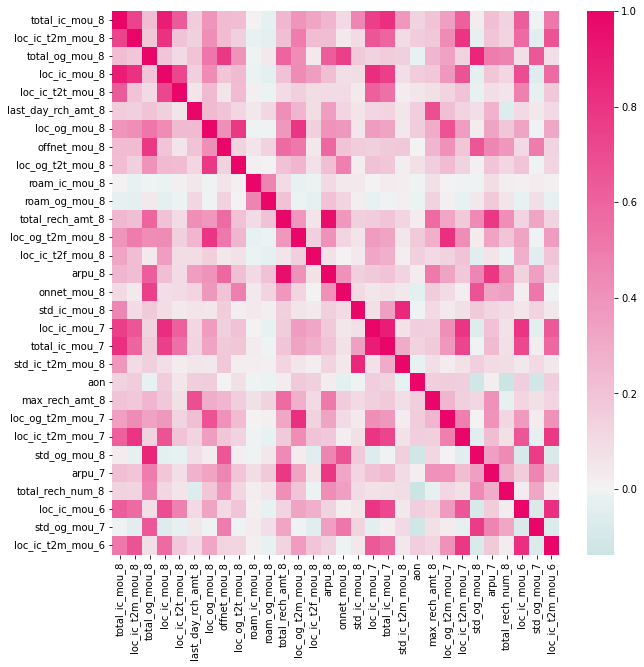

In [105]:
# plot feature correlation
plt.rcParams["figure.figsize"] =(10,10)
mycmap = sns.diverging_palette(199, 359, s=99, center="light", as_cmap=True)
sns.heatmap(data=X_train[top_features].corr(), center=0.0, cmap=mycmap)
plt.show()

In [106]:
X_train[top_features].corr()

,total_ic_mou_8,loc_ic_t2m_mou_8,total_og_mou_8,loc_ic_mou_8,loc_ic_t2t_mou_8,last_day_rch_amt_8,loc_og_mou_8,offnet_mou_8,loc_og_t2t_mou_8,roam_ic_mou_8,...,aon,max_rech_amt_8,loc_og_t2m_mou_7,loc_ic_t2m_mou_7,std_og_mou_8,arpu_7,total_rech_num_8,loc_ic_mou_6,std_og_mou_7,loc_ic_t2m_mou_6
total_ic_mou_8,1.000000,0.738278,0.226354,0.899337,0.635730,0.158549,0.397348,0.228606,0.219756,0.004611,...,0.141649,0.204338,0.347487,0.609434,0.030414,0.214120,0.140573,0.625472,-0.002419,0.510650
loc_ic_t2m_mou_8,0.738278,1.000000,0.183855,0.808263,0.203146,0.151665,0.414896,0.229132,0.150053,-0.020620,...,0.160710,0.179594,0.434113,0.799483,-0.028438,0.191526,0.130608,0.577757,-0.047906,0.670954
total_og_mou_8,0.226354,0.183855,1.000000,0.187494,0.106799,0.200458,0.521884,0.779971,0.402827,-0.004034,...,-0.018872,0.254254,0.338757,0.137588,0.862751,0.495039,0.473891,0.088754,0.653151,0.086524
loc_ic_mou_8,0.899337,0.808263,0.187494,1.000000,0.721264,0.147072,0.432621,0.191978,0.243145,-0.008728,...,0.159392,0.177271,0.382549,0.670820,-0.034983,0.183760,0.120017,0.701823,-0.055998,0.570645
loc_ic_t2t_mou_8,0.635730,0.203146,0.106799,0.721264,1.000000,0.058336,0.238971,0.059837,0.233022,0.011644,...,0.053867,0.074592,0.133249,0.199350,-0.015985,0.085686,0.062388,0.484366,-0.028543,0.174115
last_day_rch_amt_8,0.158549,0.151665,0.200458,0.147072,0.058336,1.000000,0.244121,0.204572,0.117299,0.047227,...,0.152202,0.685827,0.215180,0.125670,0.085848,0.268043,-0.069946,0.106197,0.041758,0.105822
loc_og_mou_8,0.397348,0.414896,0.521884,0.432621,0.238971,0.244121,1.000000,0.418820,0.779505,-0.002505,...,0.163709,0.291416,0.674515,0.360146,0.026202,0.335834,0.186379,0.334516,-0.001705,0.315649
offnet_mou_8,0.228606,0.229132,0.779971,0.191978,0.059837,0.204572,0.418820,1.000000,0.138581,0.054364,...,0.005676,0.257182,0.413706,0.182787,0.662070,0.462183,0.387667,0.106579,0.495463,0.131850
loc_og_t2t_mou_8,0.219756,0.150053,0.402827,0.243145,0.233022,0.117299,0.779505,0.138581,1.000000,0.011493,...,0.075424,0.153410,0.236039,0.135515,0.015777,0.188862,0.112962,0.189870,0.000551,0.121960
roam_ic_mou_8,0.004611,-0.020620,-0.004034,-0.008728,0.011644,0.047227,-0.002505,0.054364,0.011493,1.000000,...,0.000615,0.077539,0.006744,-0.002158,-0.002737,0.092948,0.021601,0.011786,0.025451,0.010610


In [107]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(X_train[top_features], 10))

Top Absolute Correlations
total_rech_amt_8  arpu_8              0.960939
loc_ic_mou_7      total_ic_mou_7      0.900445
total_ic_mou_8    loc_ic_mou_8        0.899337
total_og_mou_8    std_og_mou_8        0.862751
std_ic_mou_8      std_ic_t2m_mou_8    0.854089
loc_ic_mou_8      loc_ic_mou_7        0.831834
loc_ic_mou_6      loc_ic_t2m_mou_6    0.826499
total_ic_mou_8    total_ic_mou_7      0.818930
loc_og_t2m_mou_8  loc_og_t2m_mou_7    0.818287
loc_ic_t2m_mou_8  loc_ic_mou_8        0.808263
dtype: float64


## Model run for test data

In [108]:
test = eda(test)

(30000, 141)
(30000, 138)
(30000, 138)
(30000, 136)
(30000, 124)


In [109]:
test.columns

Index(['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       'roam_ic_mou_6',
       ...
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g',
       'jun_vbc_3g'],
      dtype='object', length=124)

In [127]:
test_pred = model.predict(test)

In [128]:
test_pred

array([0, 0, 1, ..., 1, 1, 0], dtype=int64)

In [129]:
series = pd.DataFrame(test_pred, columns=["churn_probability"])

In [130]:
series

,churn_probability
0,0
1,0
2,1
3,0
4,0
...,...
29995,0
29996,0
29997,1
29998,1


In [131]:
series.to_csv("./Submission.csv", encoding='utf-8')